# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [184]:
#important packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# other useful modules
import glob
import os
import logging

# Packages to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#imageio.plugins.ffmpeg.download()


PREV_LEFT_SLOPE = 0
PREV_RIGHT_SLOPE = 0
PREV_LEFT_LANE = [0,0,0]
PREV_RIGHT_LANE = [0,0,0]

def reset_vars():
    global PREV_LEFT_SLOPE 
    global PREV_RIGHT_SLOPE 
    global PREV_LEFT_LANE 
    global PREV_RIGHT_LANE 
    
    PREV_LEFT_SLOPE = 0
    PREV_RIGHT_SLOPE = 0
    PREV_LEFT_LANE = [0,0,0]
    PREV_RIGHT_LANE = [0,0,0]
    
logging.basicConfig(level=logging.INFO)
logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)
logger.disabled = True


## Edge Feature Extraction

This method extracts the lane edges from a given image. The following steps used to do this:
1. Grayscale conversion
2. Apply CLAHE filter to improve contrast and refine edge boundaries
3. Gausian blur to reduce detail 
4. Added a sobel x filter to reduce horizontal noise
4. Call Canny edge detection
5. If not enough edges, dialate to make them continuous
6. If too many edges impose higher canny threshold

In [165]:
def pre_process_canny(image, debug = False):

    # PARAMETERS
    imshape = image.shape
    kernel_size = 7
    sigma_x = 5
    sigma_y = 30
    low_canny_threshold = 25
    high_canny_threshold = low_canny_threshold * 3
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray2 = clahe.apply(gray)
    smooth = cv2.GaussianBlur(gray2, (kernel_size, kernel_size), sigma_x, sigma_y)
    
    sobelx64f = cv2.Sobel(smooth,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)
    
    canny_edges = cv2.Canny(sobel_8u, low_canny_threshold, high_canny_threshold)
    
    #kernel = np.ones((3,3), np.uint8)
    #edges = cv2.dilate(canny_edges, kernel, iterations=1) 
    edges  = canny_edges
    num_edge_pixels = len(np.nonzero(canny_edges)[0])
    logger.debug('number of edge pixels',num_edge_pixels)
    if  num_edge_pixels> 30000:
        edges = cv2.Canny(smooth, 75, 180, apertureSize=3)
        
    if debug == True:
        f, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, figsize=(12, 18))
        ax1.imshow(gray, cmap = 'Greys_r')
        ax1.set_title('grayscale', fontsize = 12)
        ax2.imshow(gray2, cmap = 'Greys_r')
        ax2.set_title('CLAHE', fontsize = 12)
        ax3.imshow(smooth, cmap = 'Greys_r')
        ax3.set_title('Gausian Blur', fontsize=12)
        ax4.imshow(edges, cmap = 'Greys_r')
        ax4.set_title('Edges', fontsize=12)    
    
    plt.show()
    
    return edges

def test_pre_process_canny(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidWhiteCurve.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    edges = pre_process_canny(img, True)

--- 
## Color Feature Extraction
This is used to extract the lane edges based on the color information. The following steps are used to acheive this:

1. Convert BGR to HSV
2. Threshold the HSV image to get only yellow colors
3. Threshold the RBG image to get only white colors
4. Or the thresholded images to create a mask
5. Bitwise-AND mask and original image
6. Erode to reduce selected pixels

In [166]:
def colorfilter(frame): 
    
    image = np.copy(frame)
    param_1 = 68
    param_2 = 60
    
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hsl = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)

    yellow_1 = cv2.inRange(hsv, np.array([90, 50, 50]), np.array([100, 255, 255]))
    yellow_2 = cv2.inRange(hsv, np.array([20, 100, 100]), np.array([50, 255, 255]))
    white_1 = cv2.inRange(image, np.array([200,200,200]), np.array([255,255,255]))
    white_2 = cv2.inRange(hsv, np.array([0,0,255-param_1]), np.array([255,20,255]))
    white_3 = cv2.inRange(hsl, np.array([0,255-param_2,0]), np.array([255,255,param_2]))
    
    mask = yellow_1 | yellow_2 |white_1 |white_2 |white_3
    
    
    res = cv2.bitwise_and(frame,frame, mask= mask)
    
    #kernel = np.ones((5,5), np.uint8)
    #img = cv2.erode(res, kernel, iterations=1)
    
    return(res[:,:,2])

def test_colorfilter(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidWhiteCurve.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    result = colorfilter(img)
    plt.imshow(result, cmap = 'Greys_r')
    plt.show()  

---
## Region of Interest Mask
 Applies an image mask.
Only keeps the region of the image defined by the polygon
formed from `vertices`. The rest of the image is set to black.
1. vertice set 1, vertices set 1 for the birds eye view
2. defining a blank mask to start with
3. defining a 3 channel or 1 channel color to fill the mask with depending on the input image
4. filling pixels inside the polygon defined by vertices with the fill color    
5. returning the image only where mask pixels are nonzero

In [167]:
def roi_mask(image):
    imshape = image.shape

    #vertices set 1
    y_max = imshape[0]-10
    y_min = 12*imshape[0]/18 # changing from 10
    x_min = imshape[1]/20
    x_1 = 7*imshape[1]/20 # change from 9
    x_2 = 13*imshape[1]/20 # change from 11
    x_max = 19*imshape[1]/20

    '''
    #vertices set 2
    y_max = imshape[0]-70
    y_min = imshape[0]/10
    x_min = 0 + 80
    x_1 = 5*imshape[1]/20
    x_2 = 15*imshape[1]/20
    x_max = imshape[1] - 80
    '''

    vertices = np.array([[(x_min,y_max), (x_1, y_min), (x_2, y_min),(x_max,y_max)]], dtype=np.int32)
    mask = np.zeros_like(image)   

    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, [vertices], ignore_mask_color)

    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def test_roi_mask(test_img_path):
    #test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidWhiteCurve.jpg'
    img = cv2.imread(test_img_path)
    if img is None:
        logger.info("Failed to load", fn)
    result = roi_mask(img)
    plt.imshow(result)
    plt.show()


## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [168]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

---
## Feature Detection

The edge and color features extracted in the previous steps are used in this step. Lines present in the given image are detected through the probablistic Hough Transform. The detected line segments are classified as  part of left lane or right lane based on a set of heuristic conditions. 

for each set of classified line segments, a representative line is created using the average slope and X intercept. 

Finally, the weighted average method is used to create a first order filter and tom ensure that the detected lines dont move abrupbtuly from one frame to the other. 


In [211]:
def line_detect(roi_frm):
    ret = 1
    h,w = roi_frm.shape   # height and width in pixels

    rho = 1             # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
    hough_threshold = 30      # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    raw_image = np.zeros((h,w,3), np.uint8) # creating a blank to draw raw lines on
    line_image = np.zeros((h,w,3), np.uint8) # creating a blank to draw lines on
    
    # Run Probabilistic Hough Transform to extract line segments from Binary image.
    lines = cv2.HoughLinesP(roi_frm,rho,theta,hough_threshold,min_line_length,max_line_gap)

    
    #Variable decleration
    
    y_max = int(h - 10)
    y_min = int(11 * h / 18)
    
    logger.debug('y_max=',y_max,'y_min=',y_min)

    global PREV_LEFT_SLOPE, PREV_RIGHT_SLOPE, PREV_LEFT_LANE, PREV_RIGHT_LANE
    prev_weight = 0.9

    r_Y_arr = []
    r_X_arr = []
    r_Slope_arr = []
    r_intercept = []

    l_Y_arr = []
    l_X_arr = []
    l_Slope_arr = []
    l_intercept = []


    logger.info(' processing ...')
    # Loop for every single line detected by Hough Transform
    
    #exception in no lines are found
    if lines is None: 
        r_Slope_arr.append(PREV_RIGHT_SLOPE)
        r_X_arr.append(PREV_RIGHT_LANE[0])
        r_X_arr.append(PREV_RIGHT_LANE[2])
        r_Y_arr.append(PREV_RIGHT_LANE[1])
        r_Y_arr.append(y_max)
        r_intercept.append(PREV_RIGHT_LANE[2])
        
        l_Slope_arr.append(PREV_LEFT_SLOPE)
        l_X_arr.append(PREV_LEFT_LANE[0])
        l_X_arr.append(PREV_LEFT_LANE[2])
        l_Y_arr.append(PREV_LEFT_LANE[1])
        l_Y_arr.append(y_max)
        l_intercept.append(PREV_LEFT_LANE[2])
        
    else:
        logger.info('%d lines detect ...' % lines.shape[0])
        for line in lines:
            for x1,y1,x2,y2 in line:
                dx = x2 - x1 + 0.0001
                dy = y2 - y1
                #slope, yint = np.polyfit((x1, x2), (y1, y2), 1)
                slope = dy / dx
                theta = np.abs(np.arctan2((y2-y1), (x2-x1)))
                angle = theta * (180/np.pi)
                #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
                logger.debug(x1, y1, x2, y2, angle, slope)
                if abs(angle)>10:         #for removing horizontal lines
                    # Right lane marking -> positive slope and in right half of the frame
                    logger.debug(x1, y1, x2, y2, angle, slope)
                    if x1 > 0.4*w and x2 > 0.4*w and slope > 0:
                        r_Y_arr.extend([y1,y2])
                        r_X_arr.extend([x1,x2])
                        #r_XY_arr = np.append(r_XY_arr,[[x1,x2],[y1,y2]],1)
                        r_Slope_arr.append(slope)
                        if angle>89.9:
                            x_int = x1
                        else:
                            x_int =  int(x1 + (-y_max + y1) / - slope)
                        r_intercept.append(x_int)
                        logger.debug('right',x1,y1,x2,y2,slope,angle,x_int) 
                        cv2.line(raw_image,(x1,y1),(x2,y2),(0,0,255),10)
                    # left lane marking -> negative slope and in left half of the frame
                    elif x1 < 0.6*w and x2 < 0.6*w and slope < 0:
                        l_Y_arr.extend([y1,y2])
                        l_X_arr.extend([x1,x2])
                        #l_XY_arr = np.append(l_XY_arr,[[x1,x2],[y1,y2]],1)
                        l_Slope_arr.append(slope)
                        if angle>89.9:
                            x_int = x1
                        else:
                            x_int =  int(x1 + (-y_max + y1) / - slope)
                        l_intercept.append(x_int)
                        logger.debug('left',x1,y1,x2,y2,slope,angle,x_int)
                        cv2.line(raw_image,(x1,y1),(x2,y2),(0,0,255),10)

    data_lanes = np.array((l_Slope_arr,r_Slope_arr,l_Y_arr,l_X_arr,r_Y_arr,r_X_arr))

    # Right Lane
    if r_Y_arr:
        r_x2 = np.average(r_intercept)
        r_slope = np.average(r_Slope_arr)
        
        # Update slope 
        if PREV_RIGHT_SLOPE !=0:
            r_slope = r_slope + (PREV_RIGHT_SLOPE - r_slope) * prev_weight

        logger.debug('R_slope=',r_slope)
        logger.debug('r_x2=',r_x2)
        
        r_x2 = int(r_x2)
        r_y2 = int(y_max)
        r_y1 = int(y_min)
        r_x1 = int(r_x2 + (-r_y2 + r_y1)/ r_slope)
    
        # Update rest of the cordinates
        if PREV_RIGHT_SLOPE !=0:
            r_x1 = int(r_x1 + (PREV_RIGHT_LANE[0] - r_x1) * prev_weight)
            r_y1 = int(r_y1 + (PREV_RIGHT_LANE[1] - r_y1) * prev_weight)
            r_x2 = int(r_x2 + (PREV_RIGHT_LANE[2] - r_x2) * prev_weight)

        PREV_RIGHT_SLOPE = r_slope
        PREV_RIGHT_LANE = [r_x1, r_y1, r_x2]
        logger.debug('Right',r_x1, r_y1, r_x2, y_max,r_slope)
        cv2.line(line_image, (r_x1, r_y1), (r_x2, r_y2), (255,0,0), 10)
    else:
        logger.warning('No Right Lane!!!')
        ret = 0


    # Left Lane
    if l_Y_arr:
        l_x2 = np.average(l_intercept)
        l_slope = np.average(l_Slope_arr)
        
        if PREV_LEFT_SLOPE !=0:
            l_slope = l_slope + (PREV_LEFT_SLOPE - l_slope) * prev_weight

        l_x2 = int(l_x2)
        l_y2 = y_max
        l_y1 = y_min
        l_x1 = int(l_x2 + (-l_y2 + l_y1) /l_slope)
        
        logger.debug('l_slope=',l_slope)
        logger.debug('l_x2=',l_x2)

        if PREV_LEFT_SLOPE !=0:
            l_x1 = int(l_x1 + (PREV_LEFT_LANE[0] - l_x1) * prev_weight)
            l_y1 = int(l_y1 + (PREV_LEFT_LANE[1] - l_y1) * prev_weight)
            l_x2 = int(l_x2 + (PREV_LEFT_LANE[2] - l_x2) * prev_weight)

        PREV_LEFT_SLOPE = l_slope
        PREV_LEFT_LANE = [l_x1, l_y1, l_x2]
        logger.debug('Left' ,l_x1, l_y1, l_x2, y_max,l_slope)
        cv2.line(line_image, (l_x1, l_y1), (l_x2, l_y2), (255,0,0), 10)
    else:
        logger.warning('No Left Lane !!!')
        ret = 0
    
    return(ret,line_image,raw_image)
    

---
## Processing Pipeline

The pipeline method recieves the input image and provides annotated image with lane markers identified. This pipeline can be used to process images or frames from a video. The following steps are impemented in this method:
1. Recieve image
2. Edge and color based feature extraction
3. Line detection and lane marking
4. Transform the line markings from a birds eye view to perspective projection
5. Combine line markings to the recieved image 

**pipeline**(image,test_im = True,debug = False, raw_out = False):
 - image : Input image
 - test_im = True: For video input, set to False to apply moving average lane tracking
 - debug = False: Set to True to disply various stages of the pipeline 
 - raw_out = False: Set to True to display raw hough lines on the image
 - save = False: Set to true to save the pipeline steps

In [240]:
def pipeline(image,test_im = True, debug = False, raw_out = False, save = False):
    logger.info('Pipeline initiated ...')
    if test_im:
        reset_vars()
    
    frame = np.copy(image)
    img_size = frame.shape

    canny_edges = pre_process_canny(frame)
    logger.info('Canny edges',canny_edges.shape)
    lane_pixels = colorfilter(frame)
    logger.info('Thresholding edges',lane_pixels.shape)
    hough_input = roi_mask(canny_edges + lane_pixels)
    
    ret, line_image, raw_image = line_detect(hough_input)
    
    combo_1 = weighted_img(raw_image, frame, α=0.8, β=1., λ=0.)
    
    combo_2 = weighted_img(line_image, frame, α=0.8, β=1., λ=0.)
    
    logger.info('... Pipeline complete!')
    
    if debug:
        print('Output at different states of the pipeline')
        f, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8)) = plt.subplots(8, 1, figsize=(12, 18))
        ax1.imshow(frame)
        ax1.set_title('original image', fontsize = 12)
        ax2.imshow(canny_edges, cmap = 'Greys_r')
        ax2.set_title('Canny Edges', fontsize=12)
        ax3.imshow(lane_pixels, cmap = 'Greys_r')
        ax3.set_title('Color Filter', fontsize=12)
        ax4.imshow(hough_input, cmap = 'Greys_r')
        ax4.set_title('Hough Input', fontsize = 12) 
        ax5.imshow(hough_input, cmap = 'Greys_r')
        ax5.set_title('Raw Hough Lines', fontsize = 12)
        ax6.imshow(raw_image, cmap = 'Greys_r')
        ax6.set_title('Filtered Hough line', fontsize=12)
        ax7.imshow(combo_1, cmap = 'Greys_r')
        ax7.set_title('Image with raw lines', fontsize=12)
        ax8.imshow(combo_2)
        ax8.set_title('Image with filtered lines', fontsize=12)

        plt.show()
        
    if save:
        print('saving... ')
        save_path = './Readme_resources'
        cv2.imwrite(save_path+'/frame.png',frame)
        cv2.imwrite(save_path+'/canny_edges.png',canny_edges)
        cv2.imwrite(save_path+'/color_filter.png',lane_pixels)
        cv2.imwrite(save_path+'/hough_input.png',hough_input)
        cv2.imwrite(save_path+'/raw_image.png',raw_image)
        cv2.imwrite(save_path+'/combo_1.png',combo_1)
        cv2.imwrite(save_path+'/combo_2.png',combo_2)
    
    if raw_out:
        return (combo_1)
    else:
        return(combo_2)
    

In [242]:
def test_pipeline():
    test_img_path = '/Users/enterprise/Dev/Git/CarND-LaneLines-P1/test_images/solidYellowCurve.jpg'
    
    img = mpimg.imread(test_img_path)
    logger.info('Processing... '+test_img_path)
    if img is None:
        logger.debug("Failed to load", fn)

    result = pipeline(img,True, True)
    logger.info('OK')

---
## Test Methods
### Testing the given image set

**test_images**(test_images_path, save = False, plot = True):
 - test_image_path: Directory path containing the images
 - output_image_path: Directory path to save the output images
 - save: Boolean. True to save output images to the specified outptu directory
 - plot: Boolean. True to plot the results


In [219]:
# Test Images
def test_images(test_images_path,output_image_path, save = False, plot = True):

    # create image list    
    for ind, fn in enumerate(test_images_path):
        print('processing %s... ' % fn, end='')
        img = mpimg.imread(fn)
        if img is None:
            print("Failed to load", fn)
            continue
        result = pipeline(img,True,False)
        print('ok',ind)
        infile = os.path.basename(fn)
        outfile = (output_image_path+infile+'_output.png')
        if save:
            #plt.imshow(result)
            cv2.imwrite(outfile,result)
        
    
        if plot:
            fig, ((axs1, axs2)) = plt.subplots(1,2, figsize=(12, 18), facecolor='w', edgecolor='k')
            axs1.imshow(img)
            axs1.set_title('Input:'+fn, fontsize = 12)
            axs2.imshow(result)
            axs2.set_title('Output:'+outfile, fontsize = 12)
            plt.show()
        
        result = None
    return

### Testing the given Video set

**test_videos**(video_file, output_video_path):
 - video_file: Video file path
 - output_video_path: Output path for the video
 
 Information regarding Codecs and video extension courtesy: [http://www.pyimagesearch.com/2016/02/22/writing-to-video-with-opencv/]

In [229]:
def test_videos(video_file, output_video_path):
    
    #test_video_path = test_videos_dir + '/' + video_file + '.mp4'
    test_video_path = video_file + '.mp4'
    
    cap = cv2.VideoCapture(test_video_path)
    print("Processing... "+video_file,end='')
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(7)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = None
    (h,w) = (None, None)
    zeros = None
    reset_vars()
    #infile = os.path.basename(video_file)
    outfile = (output_video_path+video_file+'_output.avi')
    cnt = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            cnt+= 1
            if writer is None:
                (h,w) = frame.shape[:2]
                writer = cv2.VideoWriter(outfile,fourcc, fps, (w,h),True)
                
            result = pipeline(frame,test_im = False)
            writer.write(result)
            
        else:
            break
    print('   Done! output saved at: ',outfile)
    # Release everything if job is finished
    cap.release()
    writer.release()
    return()

### Main

The main functions defines the directories for various inputs can calls the following functions:

1. test_pipeline : To demonstrate the various stages of the pipeline for a sample image

2. test_images : Demonstrate the pipeline on the test images

3. test_videos : Demonstrate the pipeline working on the following videos:
    - `challenge.mp4`
    - `solidWhiteRight.mp4`
    - `solidYellowLeft.mp4`

Output at different states of the pipeline


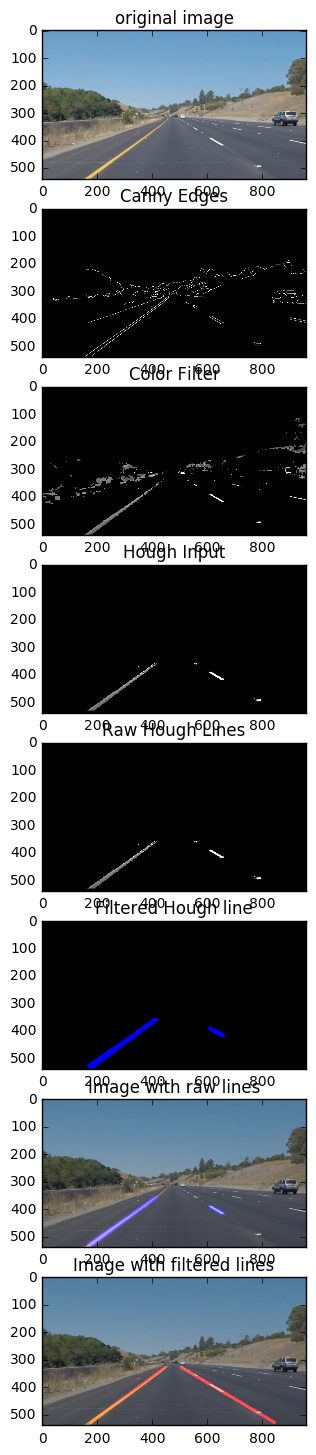

processing test_images/solidWhiteCurve.jpg... ok 0


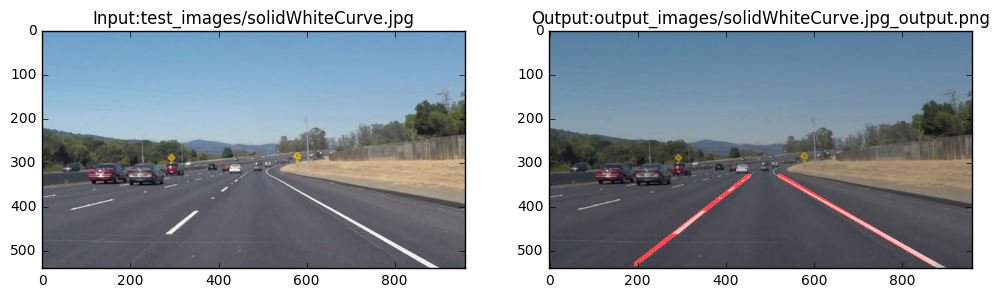

processing test_images/solidWhiteRight.jpg... ok 1


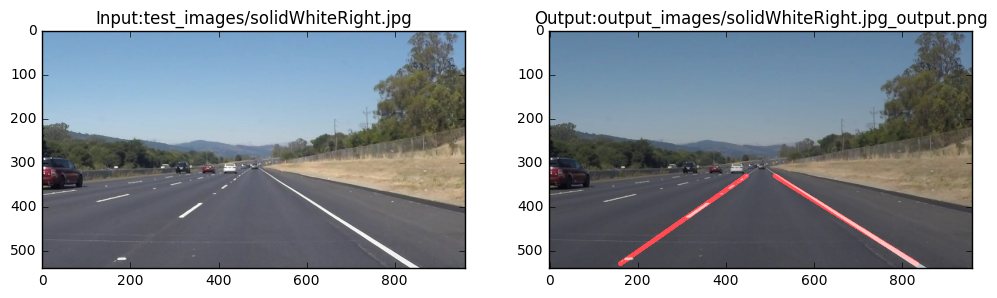

processing test_images/solidYellowCurve.jpg... ok 2


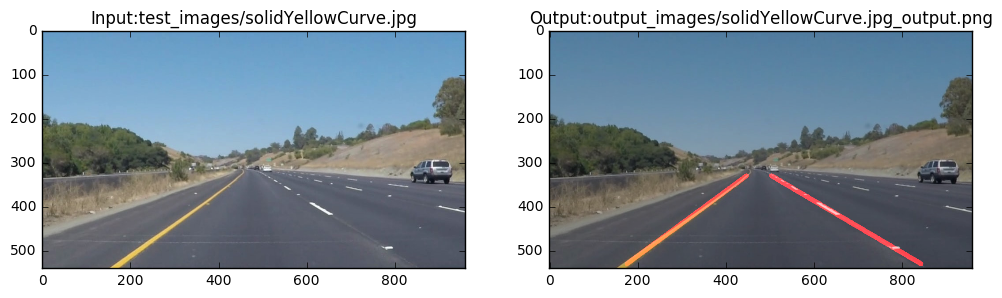

processing test_images/solidYellowCurve2.jpg... ok 3


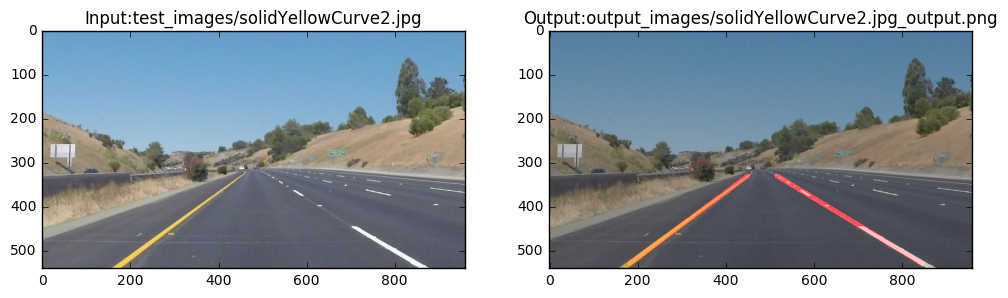

processing test_images/solidYellowLeft.jpg... ok 4


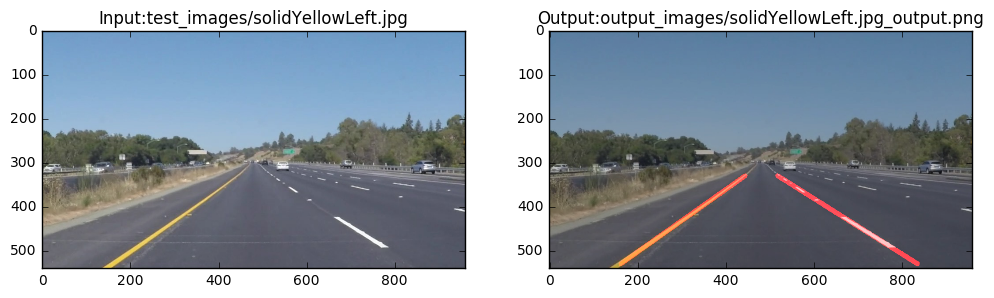

processing test_images/whiteCarLaneSwitch.jpg... ok 5


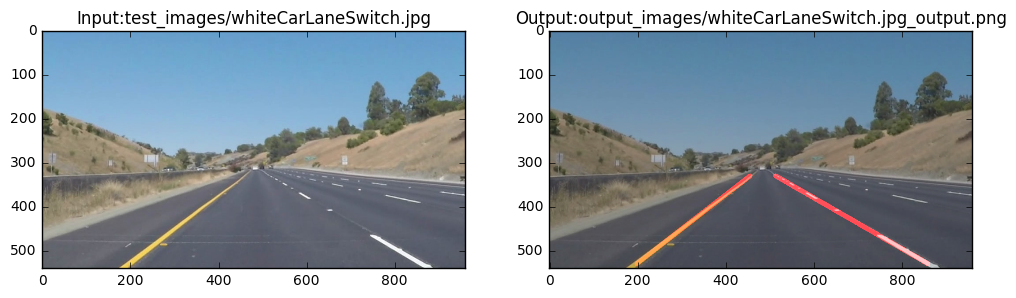

Processing... challenge   Done! output saved at:  output_videos/challenge_output.avi
Processing... solidWhiteRight   Done! output saved at:  output_videos/solidWhiteRight_output.avi
Processing... solidYellowLeft   Done! output saved at:  output_videos/solidYellowLeft_output.avi


In [243]:
def main():
    test_images_dir = 'test_images'
    test_videos_dir = ''
    vid_files = ['challenge','solidWhiteRight','solidYellowLeft']
    
    test_images_path = glob.glob(test_images_dir+'/*.jpg')
    
    output_image_path = 'output_images/'
    output_video_path = 'output_videos/'
    #output_video_path = 'output_videos/'
    
    #test_pre_process_canny(test_img_path)
    #test_colorfilter(test_img_path)
    #test_roi_mask()
    
    test_pipeline()
    
    test_images(test_images_path,output_image_path,False,True)
    
    # challenge.mp4
    test_videos(vid_files[0],output_video_path)
    
    # soldWhiteRight.mp4
    test_videos(vid_files[1],output_video_path)
    
    #solidYellowLeft.mp4
    test_videos(vid_files[2],output_video_path)
    
    
if __name__ == "__main__":
    main()

## Summary and Reflection

[Git-Repository](https://github.com/aksagg88/Advanced-Lane-Detection.git)

This report demonstrates the implementation of a basic lane detection algorithm using a combination of the edge and color based feature extraction and Hough line detection. Though the concept of the algorithm was relatively simple, the actual was a lot harder than I my expectation. After implementing this lane detection pipeline, I have a greater appreciation of the challenges in deploying a vision based in real world setting.

The feature extraction method used in this algorithm leaves a lot more to be desired. Specially in driving situations with shadow cover and faded lanes the algorithm is unable to detect lanes. using a first order filter improves the performance a little bit but a better detection and tracking method is required.

Although the implemented algorithm was able to detect the straight line segments of the lane markings in the challenge video, in an real world implementation curved lanes need to be detected. A different approach with inverse perspective mapping and  spline fitting may solve this problem.
